### <b>Table of Content</b>

0. Import functions

1. Load data

2. Create Bollinger Bands

### <b>0. Import functions</b>

In [1]:
import sys
import os
from pathlib import Path

from utils.load import load_dataframes
from utils.transform import convert_vol_to_float

### <b>1. Load data</b>

In [2]:
# Details of the source file in G Drive
base_url = "https://drive.google.com/file/d/"
file_id = "1MiunF_O8eNWIcfaOA4PVm668RN7FgLNA0a6U4LWf5Bk"
file_url = f"{base_url}{file_id}"
file_name = "2020Q1Q2Q3Q4-2021Q1.xlsx"

# Manually define sheet names as xlsx files have a 31-character limitation on sheet names.
full_sheet_names = [
    "Russia - Sberbank Rossii PAO (SBER)",
    "Turkey - Koc Holding AS (KCHOL)",
    "Egypt - Medinet Nasr Housing (MNHD)",
    "Brazil - Minerva SA/Brazil (BEEF3)",
    "Argentina - Pampa Energia SA (PAMP)",
    "Colombia - Cementos Argos SA (CCB)",
    "South Africa - Impala Platinum Holdings Ltd (IMPJ)",
    "South Korea - Dongkuk Steel Mill Co Ltd (001230)"
]

# Details of local directories
root_dir = sys.path[0]
download_dir = Path(root_dir) / "data"
file_path = download_dir / file_name

if os.path.exists(file_path):
    print(f"File {file_name} already exists in {download_dir}.")
else:
    if os.getcwd() != download_dir:
        os.chdir(download_dir)
    print(f"File {file_name} is not found in {download_dir}.")
    !gdown 1MiunF_O8eNWIcfaOA4PVm668RN7FgLNA0a6U4LWf5Bk

if os.getcwd() != root_dir:
    os.chdir(root_dir)

File 2020Q1Q2Q3Q4-2021Q1.xlsx already exists in c:\Users\Admin\Documents\GitHub\Apziva\FAxAtx2ZjFTGstEu\data.


In [23]:
data_dfs = load_dataframes(file_path, full_sheet_names)
print(f"{len(data_dfs)} DataFrames loaded with the following sheet names:\n")
for sheet_name in full_sheet_names:
    print(sheet_name)

print("\n\nBasic info of the first DateFrame:\n")
print(data_dfs[full_sheet_names[0]].info())

print("\n\nTail of the first DataFrame:")
data_dfs[full_sheet_names[0]].tail()

8 DataFrames loaded with the following sheet names:

Russia - Sberbank Rossii PAO (SBER)
Turkey - Koc Holding AS (KCHOL)
Egypt - Medinet Nasr Housing (MNHD)
Brazil - Minerva SA/Brazil (BEEF3)
Argentina - Pampa Energia SA (PAMP)
Colombia - Cementos Argos SA (CCB)
South Africa - Impala Platinum Holdings Ltd (IMPJ)
South Korea - Dongkuk Steel Mill Co Ltd (001230)


Basic info of the first DateFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      311 non-null    datetime64[ns]
 1   Price     311 non-null    float64       
 2   Open      311 non-null    float64       
 3   High      311 non-null    float64       
 4   Low       311 non-null    float64       
 5   Vol.      311 non-null    object        
 6   Change %  311 non-null    float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 17.1+ KB
None


Ta

,Date,Price,Open,High,Low,Vol.,Change %
306,2020-01-10,258.19,257.86,259.25,256.88,18.85M,0.0008
307,2020-01-09,257.99,259.40,261.76,257.01,38.33M,-0.0045
308,2020-01-08,259.15,253.57,259.15,253.03,40.82M,0.0207
309,2020-01-06,253.90,254.75,254.84,251.40,22.35M,-0.0043
310,2020-01-03,255.00,255.99,258.19,253.70,35.85M,0.0010


Convert the Vol. column from string (object) to float so that it can be fed into a regression model.

Also, only select rows where date is in 2020 as training data and rows in 2021 as test date.

In [26]:
train_dfs = {}
for name, df in data_dfs.items():
    df_copy = df.copy()
    df_copy['Vol.'] = df_copy['Vol.'].apply(convert_vol_to_float)
    train_df = df_copy[df_copy['Date'].dt.year == 2020].set_index('Date')
    test_df = df_copy[df_copy['Date'].dt.year == 2021].set_index('Date')
    train_dfs[name] = (train_df, test_df)

2. Create Bollinger Bands for 2020 for each company

Typical values used:

Short term: 10 day moving average, bands at 1.5 standard deviations. (1.5 times the standard dev. +/- the SMA)

Medium term: 20 day moving average, bands at 2 standard deviations.

Long term: 50 day moving average, bands at 2.5 standard deviations.

(Timestamp('2020-01-03 00:00:00'), Timestamp('2020-12-30 00:00:00'))

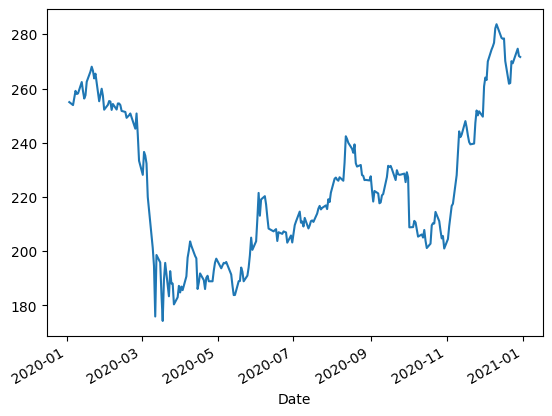

In [28]:
df_1_train, df_1_test = train_dfs[full_sheet_names[0]]
df_1_train['Price'].plot()
df_1_train.index.min(), df_1_train.index.max()

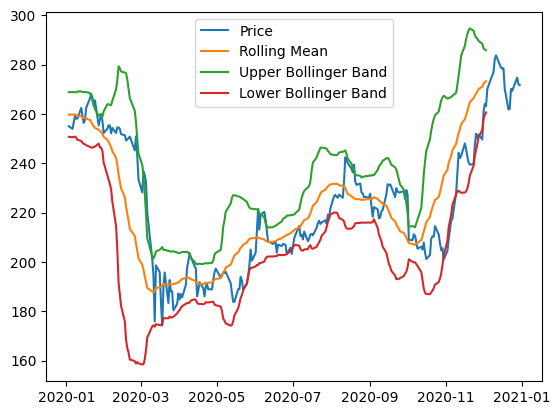

In [29]:
import matplotlib.pyplot as plt

# Define time period and calculate rolling mean and standard deviation
time_period = 20
rolling_mean = df_1_train['Price'].rolling(window=time_period).mean()
rolling_std = df_1_train['Price'].rolling(window=time_period).std()

# Calculate upper and lower Bollinger Bands
upper_band = rolling_mean + (rolling_std * 2)
lower_band = rolling_mean - (rolling_std * 2)


# Plot the data and the Bollinger Bands
plt.plot(df_1_train['Price'], label='Price')
plt.plot(rolling_mean, label='Rolling Mean')
plt.plot(upper_band, label='Upper Bollinger Band')
plt.plot(lower_band, label='Lower Bollinger Band')
plt.legend()
plt.show()

In [30]:
import pandas as pd
import statsmodels.api as sm

# Load time series data into a pandas DataFrame
# data = pd.read_csv('time_series_data.csv', index_col='date', parse_dates=True)

# Define the independent variable(s) (e.g. other time series data)
independent_variable = df_1_train.loc[:, df_1_train.columns != 'Price']

# Define the dependent variable (i.e. the time series data to be analyzed)
dependent_variable = df_1_train['Price']

# Create the regression model and fit it to the data
model = sm.OLS(dependent_variable, sm.add_constant(independent_variable)).fit()

# Print the summary of the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 1.814e+04
Date:                Sun, 14 May 2023   Prob (F-statistic):          2.03e-311
Time:                        21:20:16   Log-Likelihood:                -436.05
No. Observations:                 250   AIC:                             884.1
Df Residuals:                     244   BIC:                             905.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3043      0.859      0.354      0.7

In [35]:
df_1_test['Price']

Date
2021-03-31    291.02
2021-03-30    293.25
2021-03-29    293.30
2021-03-26    291.22
2021-03-25    286.66
               ...  
2021-01-11    289.49
2021-01-08    283.64
2021-01-06    272.93
2021-01-05    275.20
2021-01-04    272.00
Name: Price, Length: 61, dtype: float64

In [33]:
model.predict(df_1_test)

Date
2021-03-31    379.776035
2021-03-30    382.302246
2021-03-29    381.405745
2021-03-26    380.069734
2021-03-25    372.251388
                 ...    
2021-01-11    376.749733
2021-01-08    369.138454
2021-01-06    355.694993
2021-01-05    357.376951
2021-01-04    356.204089
Length: 61, dtype: float64

To perform time series regression with multiple independent variables in Python, you can use the VARMAX class from the statsmodels library. This class extends the VAR class to include exogenous variables, allowing you to model the relationship between multiple time series and multiple independent variables.

Here's an example of how to perform time series regression with multiple independent variables in Python using the VARMAX class:

In [34]:
import pandas as pd
from statsmodels.tsa.statespace.varmax import VARMAX

# Load time series and independent variable data into pandas DataFrames
# data = pd.read_csv('time_series_data.csv', index_col='date', parse_dates=True)
# independent_data = pd.read_csv('independent_variable_data.csv', index_col='date', parse_dates=True)

# Create the VARMAX model and fit it to the data
model = VARMAX(df_1_train, exog=independent_variable, order=(1, 1))
results = model.fit()

# Print the summary of the VARMAX model results
print(results.summary())


c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\AppData\Roaming\Python\Python38\site-packages\scipy\linalg\_solvers.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.44439e-47): result m

LinAlgError: 2-th leading minor of the array is not positive definite

In this example, the time_series_data.csv file contains multiple columns of time series data, and the independent_variable_data.csv file contains multiple columns of independent variable data, both with dates as the index. We load these data into pandas DataFrames, and create a VARMAX model using the VARMAX function from statsmodels. We specify the order of the model (i.e. the number of lags for the time series data and the independent variables) using the order parameter, and include the independent variables using the exog parameter. Finally, we fit the model to the data using the fit method, and print a summary of the VARMAX model results using the summary method.

You can customize the VARMAX model by specifying different parameters, such as the type of error structure (e.g. VARMAX, VARMA, etc.), the method for estimating the model parameters (e.g. maximum likelihood, Bayesian, etc.), and the type of exogenous variables (e.g. deterministic, stochastic, etc.). The statsmodels library provides a wide range of options for VARMAX modeling, so be sure to consult the documentation for more information.